## Batch correction and data integration Demonstrations
### scRNA-seq analysis in Python course 2024, EBI

#### Preparation

In [6]:
# package dependencies and suppress unnecessary warning messages 
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning, NumbaWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaWarning)

In [7]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

In [8]:
pd.set_option('display.max_columns', 40)

In [9]:
import harmonypy

In [10]:
# reproducibility
seed = 10
np.random.seed(seed)

#### Load files and create concatenated object

In [19]:
# Read files, here we only use two samples as an example to run batch correction / data integration

In [20]:
adata_1a = sc.read_h5ad("../Data/PBMMC_1a_dimRed.h5ad")

In [21]:
adata_1b = sc.read_h5ad("../Data/PBMMC_1b_dimRed.h5ad")

In [22]:
adata_1a.shape

(846, 24207)

In [23]:
adata_1b.shape

(1177, 24016)

In [24]:
# Converting column to type str for the ad.concat function
adata_1a.var = adata_1a.var.astype(str)
adata_1b.var = adata_1b.var.astype(str)

In [36]:
adata_1a.var

,ID,Symbol,Chromosome
ENSG00000243485,ENSG00000243485,MIR1302-2HG,chr1
ENSG00000238009,ENSG00000238009,ENSG00000238009,chr1
ENSG00000241860,ENSG00000241860,ENSG00000241860,chr1
ENSG00000237491,ENSG00000237491,LINC01409,chr1
ENSG00000225880,ENSG00000225880,LINC00115,chr1
...,...,...,...
ENSG00000273748,ENSG00000273748,ENSG00000273748,GL000219.1
ENSG00000271254,ENSG00000271254,ENSG00000271254,KI270711.1
ENSG00000276345,ENSG00000276345,ENSG00000276345,KI270721.1
ENSG00000276017,ENSG00000276017,ENSG00000276017,KI270734.1


In [33]:
# Key function to create a concatenated anndata object from two (or more) single-sample object
# axis = 0: concatenate cells, use = 1 for concatenate features
# join = 'inner': only shared features between two objects are kept
# merge = 'same': how to merge .var annotation as we are concatenating cells, for the shared features, keep the same .var annotation columns betwee the two .var

# label: the column added to the .obs of the merged object to indicate the individual objects
# keys: the keys that pend to the .obs_names on the merged object, also add to the "label" column in .obs
# index_unique: the delimiter between the .obs_names and the keys


adata_combined = ad.concat([adata_1a, adata_1b], 
                           axis=0, 
                           join = 'inner', 
                           merge = 'same', 
                           label='batch',
                           keys=['batch_1', 'batch_2'], 
                           index_unique='_')

In [43]:
adata_1a.n_obs + adata_1b.n_obs

2023

In [44]:
adata_combined.obs

,Barcode,sizeFactor,label,batch
AAACCTGCACTTCGAA-1_batch_1,AAACCTGCACTTCGAA-1,0.521288,8,batch_1
AAACCTGCAGACGCAA-1_batch_1,AAACCTGCAGACGCAA-1,0.568532,9,batch_1
AAAGATGCATAAAGGT-1_batch_1,AAAGATGCATAAAGGT-1,0.472943,4,batch_1
AAAGATGTCTCGAGTA-1_batch_1,AAAGATGTCTCGAGTA-1,0.217871,8,batch_1
AAAGCAACAATACGCT-1_batch_1,AAAGCAACAATACGCT-1,0.414777,14,batch_1
...,...,...,...,...
TTTATGCTCGTTGCCT-1_batch_2,TTTATGCTCGTTGCCT-1,0.491334,8,batch_2
TTTGGTTAGTCTCGGC-1_batch_2,TTTGGTTAGTCTCGGC-1,0.300197,4,batch_2
TTTGTCAGTAAATGTG-1_batch_2,TTTGTCAGTAAATGTG-1,1.311460,2,batch_2
TTTGTCAGTACAAGTA-1_batch_2,TTTGTCAGTACAAGTA-1,0.504132,8,batch_2


In [45]:
adata_combined.var

,ID,Symbol,Chromosome
ENSG00000238009,ENSG00000238009,ENSG00000238009,chr1
ENSG00000241860,ENSG00000241860,ENSG00000241860,chr1
ENSG00000237491,ENSG00000237491,LINC01409,chr1
ENSG00000225880,ENSG00000225880,LINC00115,chr1
ENSG00000228794,ENSG00000228794,LINC01128,chr1
...,...,...,...
ENSG00000276256,ENSG00000276256,ENSG00000276256,GL000195.1
ENSG00000273748,ENSG00000273748,ENSG00000273748,GL000219.1
ENSG00000271254,ENSG00000271254,ENSG00000271254,KI270711.1
ENSG00000276017,ENSG00000276017,ENSG00000276017,KI270734.1


In [37]:
# Keep an object with only raw counts
adata_combined_counts = adata_combined.copy()

In [46]:
# Note which column in the .obs of the concatenated object we intend to integrate for

batch_key = 'batch'

### Data integration
#### First check unintegrated data

In [47]:
# standard analysis without considering batch

adata_combined.layers["counts"] = adata_combined.X.copy()
sc.pp.normalize_total(adata_combined)
sc.pp.log1p(adata_combined)
adata_combined.layers["logcounts"] = adata_combined.X.copy()

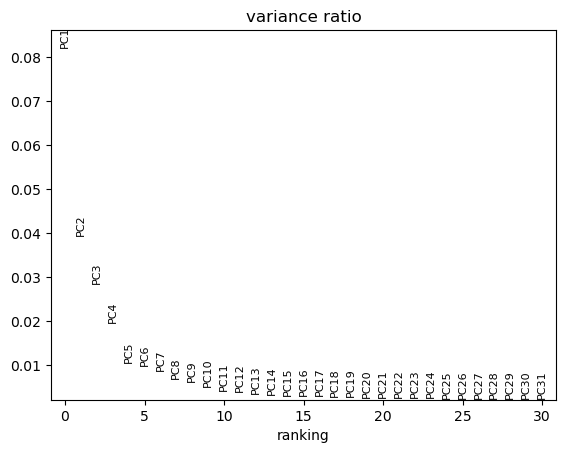

In [48]:
sc.pp.highly_variable_genes(adata_combined, flavor='seurat')
sc.tl.pca(adata_combined)
sc.pl.pca_variance_ratio(adata_combined, n_pcs=30, log=False, show=None, save=None)

In [49]:
sc.pp.neighbors(adata_combined, n_pcs=12)
sc.tl.umap(adata_combined)
adata_combined

2024-09-01 15:22:38.900938: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-01 15:22:39.517607: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


AnnData object with n_obs × n_vars = 2023 × 21749
    obs: 'Barcode', 'sizeFactor', 'label', 'batch'
    var: 'ID', 'Symbol', 'Chromosome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'logcounts'
    obsp: 'distances', 'connectivities'

In [52]:
matplotlib.rcParams['figure.figsize'] = [6, 6]

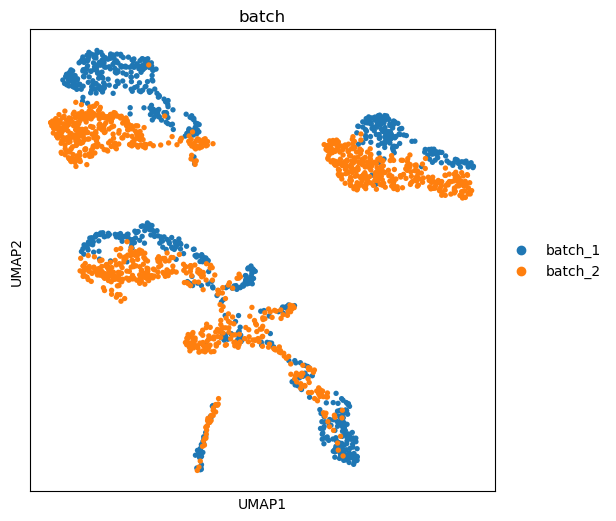

In [53]:
sc.pl.umap(adata_combined, color=[batch_key], wspace=1, ncols=1)

In [ ]:
# Unintegrated data suggest quite some batch effect exists between the two batches

#### Batch-aware feature selection

In [54]:
# The first step to perform data integration is to re-select the HVGs being aware of batch
# Add batch_key when selecting HVGs
# This will overwrite the previous HVGs-related column values in the .var table and add some new columns
sc.pp.highly_variable_genes(
    adata_combined, n_top_genes=2000, flavor="cell_ranger", batch_key=batch_key
)

In [55]:
adata_combined

AnnData object with n_obs × n_vars = 2023 × 21749
    obs: 'Barcode', 'sizeFactor', 'label', 'batch'
    var: 'ID', 'Symbol', 'Chromosome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'batch_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'logcounts'
    obsp: 'distances', 'connectivities'

In [56]:
# Note the highly_variable_nbatches and the highly_variable_intersection column
adata_combined.var

,ID,Symbol,Chromosome,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection
ENSG00000238009,ENSG00000238009,ENSG00000238009,chr1,False,0.001109,0.596376,0.131413,0,False
ENSG00000241860,ENSG00000241860,ENSG00000241860,chr1,True,0.002073,0.825203,1.389519,1,False
ENSG00000237491,ENSG00000237491,LINC01409,chr1,False,0.023695,0.729940,0.248438,0,False
ENSG00000225880,ENSG00000225880,LINC00115,chr1,False,0.002493,0.814119,0.528333,0,False
ENSG00000228794,ENSG00000228794,LINC01128,chr1,False,0.010685,0.603632,-1.155363,0,False
...,...,...,...,...,...,...,...,...,...
ENSG00000276256,ENSG00000276256,ENSG00000276256,GL000195.1,False,0.002689,0.343913,-1.814459,0,False
ENSG00000273748,ENSG00000273748,ENSG00000273748,GL000219.1,False,0.035194,0.764593,0.561928,0,False
ENSG00000271254,ENSG00000271254,ENSG00000271254,KI270711.1,False,0.017971,0.809606,0.911032,0,False
ENSG00000276017,ENSG00000276017,ENSG00000276017,KI270734.1,False,0.000256,0.273243,-0.454976,0,False


highly_variable_nbatches
0    18430
1     2638
2      681
Name: count, dtype: int64

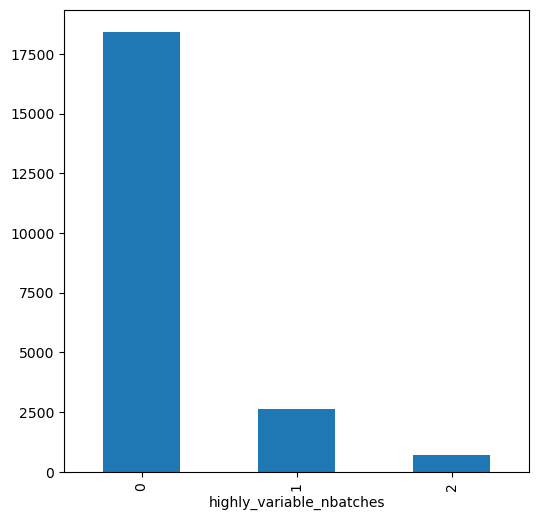

In [58]:
# See how many batches the gene is highly variable in

n_batches = adata_combined.var["highly_variable_nbatches"].value_counts()
ax = n_batches.plot(kind="bar")
n_batches

#### Example: integration with harmony

In [59]:
# move the unintegrated umap
adata_combined.obsm['X_umapraw'] = adata_combined.obsm['X_umap']

In [60]:
# run harmony via scanpy external API
sc.external.pp.harmony_integrate(adata_combined, key=batch_key, basis = 'X_pca')

2024-09-01 15:24:32,901 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-09-01 15:24:33,817 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-09-01 15:24:33,821 - harmonypy - INFO - Iteration 1 of 10
2024-09-01 15:24:34,010 - harmonypy - INFO - Iteration 2 of 10
2024-09-01 15:24:34,200 - harmonypy - INFO - Iteration 3 of 10
2024-09-01 15:24:34,385 - harmonypy - INFO - Iteration 4 of 10
2024-09-01 15:24:34,466 - harmonypy - INFO - Iteration 5 of 10
2024-09-01 15:24:34,527 - harmonypy - INFO - Iteration 6 of 10
2024-09-01 15:24:34,589 - harmonypy - INFO - Converged after 6 iterations


In [61]:
# Note that a new embedding, which we named X_pca_harmony is generated
adata_combined

AnnData object with n_obs × n_vars = 2023 × 21749
    obs: 'Barcode', 'sizeFactor', 'label', 'batch'
    var: 'ID', 'Symbol', 'Chromosome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'batch_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_umapraw', 'X_pca_harmony'
    varm: 'PCs'
    layers: 'counts', 'logcounts'
    obsp: 'distances', 'connectivities'

In [62]:
# recalculate neighbours and umap based on harmony corrected embedding

sc.pp.neighbors(adata_combined, use_rep='X_pca_harmony', key_added = 'harmony', n_neighbors=15, n_pcs=40)
sc.tl.umap(adata_combined, neighbors_key = 'harmony')

In [63]:
matplotlib.rcParams['figure.figsize'] = [5, 6]

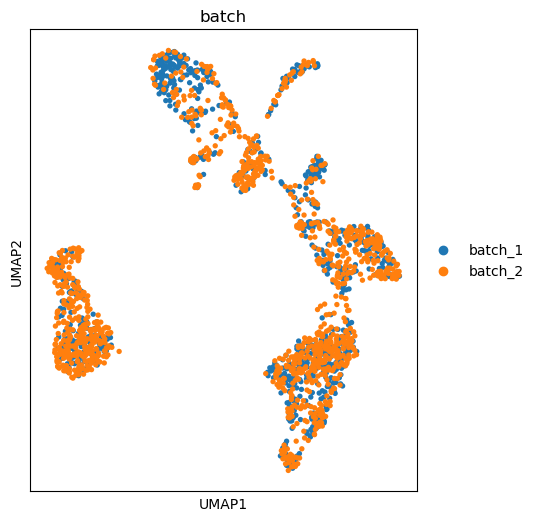

In [64]:
sc.pl.umap(adata_combined, color=[batch_key], ncols=1)

In [65]:
# Move harmony corrected umap to distinguish it from the uncorrected one
adata_combined.obsm['X_umapharmony'] = adata_combined.obsm['X_umap']